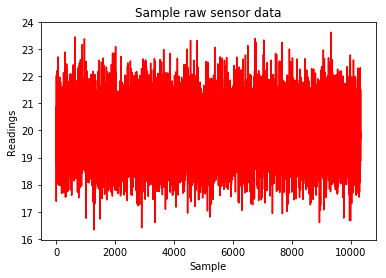

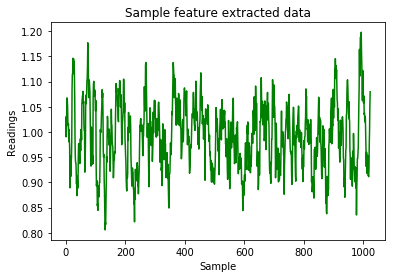

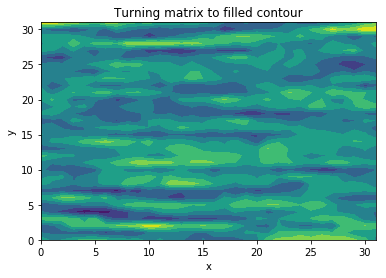

In [2]:
# Generate experiment data
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import scipy

rate=1000
window=100
slide=10
feature=1024
n=feature*slide+window-slide
group=3
p=100

u=[10,20,30]
s=[5,1,10]

labelsTrain=np.zeros(shape=(group*p))
labelsTest=np.zeros(shape=(group))

rawTrain=np.zeros(shape=(p*group,n))
rawTest=np.zeros(shape=(group,n))
rawFTrain=np.zeros(shape=(p*group,feature))
rawFTest=np.zeros(shape=(group,feature))

for i in np.arange(0,p):
    for j in np.arange(0,group):
        labelsTrain[i*group+j]=j
        rawTrain[i*group+j,:]=np.random.normal(u[j],s[j],n)
        
for j in np.arange(0,group):
    rawTest[j,:]=np.random.normal(u[j],s[j],n)
    labelsTest[j]=j

for i in np.arange(0,p):
    for j in np.arange(0,group):
        for k in np.arange(0,feature):
            #rawFTrain[i*group+j,k]=np.mean(rawTrain[i*group+j,k*slide:k*slide+window-1])
            rawFTrain[i*group+j,k]=np.std(rawTrain[i*group+j,k*slide:k*slide+window-1])
        
for j in np.arange(0,group):
    for k in np.arange(0,feature):
        #rawFTest[j,k]=np.mean(rawTest[j,k*slide:k*slide+window-1])
        rawFTest[j,k]=np.std(rawTest[j,k*slide:k*slide+window-1])
        
#Shuffle training raw data
index=np.arange(0,p*group)
np.random.shuffle(index)
rawFTrain=rawFTrain[index]
labelsTrain=labelsTrain[index]
# Shuffle done!
        
# Sample plot
plt.plot(rawTest[1,:], color='red')
plt.xlabel('Sample')
plt.ylabel('Readings')
plt.title('Sample raw sensor data')
plt.show()

plt.plot(rawFTest[1,:], color='green')
plt.xlabel('Sample')
plt.ylabel('Readings')
plt.title('Sample feature extracted data')
plt.show()

matFTrain=rawFTrain.reshape(p*group,32,32)
matFTest=rawFTest.reshape(group,32,32)

# Display as image
plt.contourf(matFTest[1,:,:])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Turning matrix to filled contour')
plt.show()

# Equivalent to torch.utils.data.DataLoader item
batch=5
channel=1
matFTest=torch.from_numpy(matFTest)
matFTest=matFTest.type(torch.FloatTensor)

matFTrain=torch.from_numpy(matFTrain)
matFTrain=matFTrain.type(torch.FloatTensor)

labelsTrain=torch.from_numpy(labelsTrain)
labelsTrain=labelsTrain.type(torch.LongTensor)

labelsTest=torch.from_numpy(labelsTest)
labelsTest=labelsTest.type(torch.LongTensor)

dataX=[] #TrainLoader
matFTrain=matFTrain.reshape(-1,batch,channel,32,32)
matFTest=matFTest.reshape(-1,1,channel,32,32)
labelsTrain=labelsTrain.reshape(-1,batch)

for i in np.arange(0,int(p*group/batch)):
    dataX.append((labelsTrain[i,:],matFTrain[i,:,:,:,:]))

# Output choices
classes = ('Red', 'Green', 'Blue')

In [21]:
#transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

import torch.nn as nn
import torch.nn.functional as F

# Defining network class
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,3)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        
        return x

net=Net()

In [26]:
# Defining optimization / Loss function
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

[1,    60] loss: 1.100
[2,    60] loss: 1.100
[3,    60] loss: 1.100
[4,    60] loss: 1.101
[5,    60] loss: 1.101
[6,    60] loss: 1.101
[7,    60] loss: 1.101
[8,    60] loss: 1.101
[9,    60] loss: 1.101
[10,    60] loss: 1.101
[11,    60] loss: 1.101
[12,    60] loss: 1.101
[13,    60] loss: 1.101
[14,    60] loss: 1.101
[15,    60] loss: 1.101
[16,    60] loss: 1.101
[17,    60] loss: 1.101
[18,    60] loss: 1.101
[19,    60] loss: 1.101
[20,    60] loss: 1.101
[21,    60] loss: 1.101
[22,    60] loss: 1.100
[23,    60] loss: 1.100
[24,    60] loss: 1.100
[25,    60] loss: 1.100
[26,    60] loss: 1.100
[27,    60] loss: 1.100
[28,    60] loss: 1.100
[29,    60] loss: 1.100
[30,    60] loss: 1.100
[31,    60] loss: 1.100
[32,    60] loss: 1.100
[33,    60] loss: 1.100
[34,    60] loss: 1.100
[35,    60] loss: 1.100
[36,    60] loss: 1.100
[37,    60] loss: 1.100
[38,    60] loss: 1.100
[39,    60] loss: 1.100
[40,    60] loss: 1.100
[41,    60] loss: 1.100
[42,    60] loss: 1.100
[

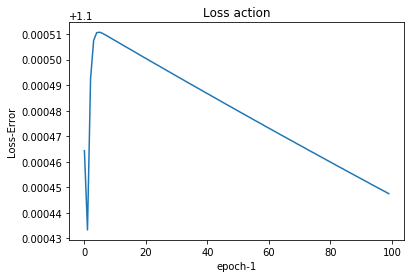

In [27]:
# Training
epo=100;
trackLoss=np.zeros(shape=(epo,1))
for epoch in range(epo):
    running_loss=0.0
    for i,data in enumerate(dataX,0):
        labels, inputs = data
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        if i % int(p*group/batch)==int(p*group/batch)-1:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/int(p*group/batch)))
            trackLoss[epoch]=running_loss/int(p*group/batch)
            running_loss=0.0
print('Done!')
# Display loss trend
plt.plot(trackLoss)
plt.xlabel('epoch-1')
plt.ylabel('Loss-Error')
plt.title('Loss action')
plt.show()

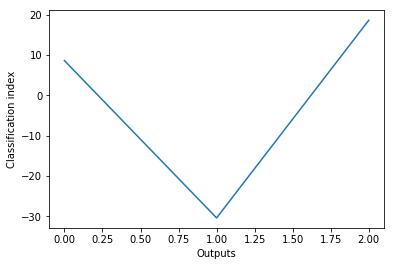

In [114]:
test=2
outputs=net(matFTest[test,:,:,:])
f=outputs.detach().numpy()
plt.plot(f[0])
plt.xlabel('Outputs')
plt.ylabel('Classification index')
plt.show()

In [101]:
temp, predicted = torch.max(outputs, 1)

In [102]:
print(temp)

tensor([8.7481], grad_fn=<MaxBackward0>)

In [103]:
print('Class predicted: {}'.format(classes[predicted]))

'Green'

In [ ]:
print('Class Tested: {}'.format(classes[labelsTest[test]]))

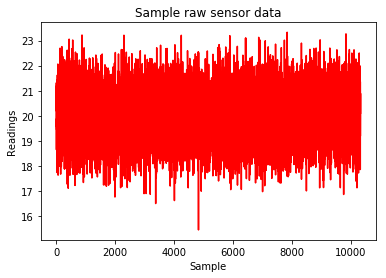

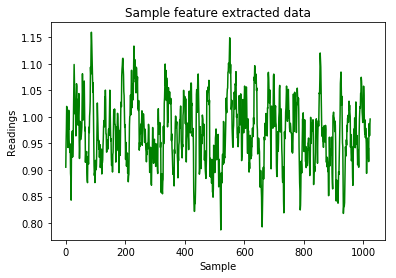

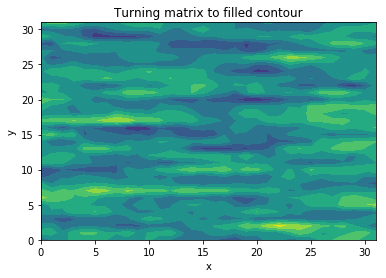

[1,    60] loss: 0.925
[2,    60] loss: 0.811
[3,    60] loss: 0.733
[4,    60] loss: 0.655
[5,    60] loss: 0.591
[6,    60] loss: 0.542
[7,    60] loss: 0.501
[8,    60] loss: 0.465
[9,    60] loss: 0.432
[10,    60] loss: 0.404
[11,    60] loss: 0.379
[12,    60] loss: 0.353
[13,    60] loss: 0.327
[14,    60] loss: 0.308
[15,    60] loss: 0.295
[16,    60] loss: 0.277
[17,    60] loss: 0.253
[18,    60] loss: 0.226
[19,    60] loss: 0.184
[20,    60] loss: 0.143
[21,    60] loss: 0.123
[22,    60] loss: 0.097
[23,    60] loss: 0.071
[24,    60] loss: 0.052
[25,    60] loss: 0.039
[26,    60] loss: 0.030
[27,    60] loss: 0.024
[28,    60] loss: 0.019
[29,    60] loss: 0.016
[30,    60] loss: 0.013
[31,    60] loss: 0.011
[32,    60] loss: 0.010
[33,    60] loss: 0.009
[34,    60] loss: 0.008
[35,    60] loss: 0.007
[36,    60] loss: 0.006
[37,    60] loss: 0.005
[38,    60] loss: 0.005
[39,    60] loss: 0.004
[40,    60] loss: 0.004
[41,    60] loss: 0.004
[42,    60] loss: 0.003
[

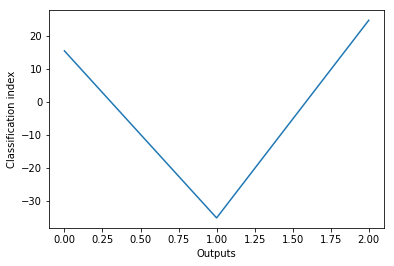

tensor([24.6669], grad_fn=<MaxBackward0>)
Class predicted: Blue
Class Tested: Blue


In [115]:
####################
# Golam Gause Jaman#
# jamagola@isu.edu #
####################


# Generate experiment data
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import scipy

rate=1000
window=100
slide=10
feature=1024
n=feature*slide+window-slide
group=3
p=100

u=[10,20,30]
s=[5,1,10]

labelsTrain=np.zeros(shape=(group*p))
labelsTest=np.zeros(shape=(group))

rawTrain=np.zeros(shape=(p*group,n))
rawTest=np.zeros(shape=(group,n))
rawFTrain=np.zeros(shape=(p*group,feature))
rawFTest=np.zeros(shape=(group,feature))

for i in np.arange(0,p):
    for j in np.arange(0,group):
        labelsTrain[i*group+j]=j
        rawTrain[i*group+j,:]=np.random.normal(u[j],s[j],n)
        
for j in np.arange(0,group):
    rawTest[j,:]=np.random.normal(u[j],s[j],n)
    labelsTest[j]=j

for i in np.arange(0,p):
    for j in np.arange(0,group):
        for k in np.arange(0,feature):
            #rawFTrain[i*group+j,k]=np.mean(rawTrain[i*group+j,k*slide:k*slide+window-1])
            rawFTrain[i*group+j,k]=np.std(rawTrain[i*group+j,k*slide:k*slide+window-1])
        
for j in np.arange(0,group):
    for k in np.arange(0,feature):
        #rawFTest[j,k]=np.mean(rawTest[j,k*slide:k*slide+window-1])
        rawFTest[j,k]=np.std(rawTest[j,k*slide:k*slide+window-1])
        
#Shuffle training raw data
index=np.arange(0,p*group)
np.random.shuffle(index)
rawFTrain=rawFTrain[index]
labelsTrain=labelsTrain[index]
# Shuffle done!
        
# Sample plot
plt.plot(rawTest[1,:], color='red')
plt.xlabel('Sample')
plt.ylabel('Readings')
plt.title('Sample raw sensor data')
plt.show()

plt.plot(rawFTest[1,:], color='green')
plt.xlabel('Sample')
plt.ylabel('Readings')
plt.title('Sample feature extracted data')
plt.show()

matFTrain=rawFTrain.reshape(p*group,32,32)
matFTest=rawFTest.reshape(group,32,32)

# Display as image
plt.contourf(matFTest[1,:,:])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Turning matrix to filled contour')
plt.show()

# Equivalent to torch.utils.data.DataLoader item
batch=5
channel=1
matFTest=torch.from_numpy(matFTest)
matFTest=matFTest.type(torch.FloatTensor)

matFTrain=torch.from_numpy(matFTrain)
matFTrain=matFTrain.type(torch.FloatTensor)

labelsTrain=torch.from_numpy(labelsTrain)
labelsTrain=labelsTrain.type(torch.LongTensor)

labelsTest=torch.from_numpy(labelsTest)
labelsTest=labelsTest.type(torch.LongTensor)

dataX=[] #TrainLoader
matFTrain=matFTrain.reshape(-1,batch,channel,32,32)
matFTest=matFTest.reshape(-1,1,channel,32,32)
labelsTrain=labelsTrain.reshape(-1,batch)

for i in np.arange(0,int(p*group/batch)):
    dataX.append((labelsTrain[i,:],matFTrain[i,:,:,:,:]))

# Output choices
classes = ('Red', 'Green', 'Blue')



#transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

import torch.nn as nn
import torch.nn.functional as F

# Defining network class
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,3)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        
        return x

net=Net()


# Defining optimization / Loss function
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training
epo=100;

for epoch in range(epo):
    running_loss=0.0
    for i,data in enumerate(dataX,0):
        labels, inputs = data
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        if i % int(p*group/batch)==int(p*group/batch)-1:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/int(p*group/batch)))
            running_loss=0.0
print('Done!')

test=2
outputs=net(matFTest[test,:,:,:])
f=outputs.detach().numpy()
plt.plot(f[0])
plt.xlabel('Outputs')
plt.ylabel('Classification index')
plt.show()

temp, predicted = torch.max(outputs, 1)
print(temp)
print('Class predicted: {}'.format(classes[predicted]))
print('Class Tested: {}'.format(classes[labelsTest[test]]))

In [43]:
rawTrain[0,:]

array([ 7.54477188, 11.03025775,  9.64552273, ...,  3.23610276,
       10.68673769, 10.26849937])

In [44]:
import pandas as pd

In [60]:
raw=pd.read_csv('C:\\Users\\Golam\\Desktop\\testy.csv', header=None, usecols=[0,2])

In [63]:
raw.values[:,0]

array([-643.16, -672.27, -662.47, ..., -231.86, -211.97, -213.11])

In [65]:
raw.values

array([[-643.16  ,   -3.3387],
       [-672.27  ,  -45.232 ],
       [-662.47  , -121.65  ],
       ...,
       [-231.86  ,  171.14  ],
       [-211.97  ,  156.31  ],
       [-213.11  ,  135.32  ]])

In [54]:
a=np.array(raw.iloc[:,0].values)

In [58]:
a.dtype

dtype('float64')

In [68]:
a[0:1000].shape

(1000,)